In [1]:
import nltk
import re
import string
import pandas as pd
import spacy
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem import PorterStemmer

# Load Spacy's English model
nlp = spacy.load("en_core_web_sm")

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Initialize tokenizer and stopword list
tokenizer = ToktokTokenizer()
stopword_list = set(stopwords.words("english"))

# Removing HTML tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing content inside square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Removing special characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Removing stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    return ' '.join(filtered_tokens)

# Text preprocessing pipeline
def preprocess_text(text, use_stemming=True):
    original_text = text  # Store original review for later
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    
    # Stemming or Lemmatization
    if use_stemming:
        stemmer = PorterStemmer()
        text = ' '.join([stemmer.stem(word) for word in text.split()])
    else:
        doc = nlp(text)
        text = ' '.join([token.lemma_ for token in doc])
    
    return original_text, text

# Load IMDB dataset
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

# Apply preprocessing
df["original_review"], df["processed_review"] = zip(*df["review"].apply(lambda x: preprocess_text(x, use_stemming=False)))

# Splitting dataset into train and test
train_reviews = df["processed_review"][:40000]
train_sentiments = df["sentiment"][:40000]
test_reviews = df["processed_review"][40000:]
test_sentiments = df["sentiment"][40000:]

# Display sample
df.head()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<ipython-input-1-54e7b1a030ee>:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,review,sentiment,original_review,processed_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,one reviewer mention watch 1 oz episode you ll...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...,basically there s family little boy Jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is...",Petter Matteis Love Time Money visually stunni...


In [2]:
df.drop(columns=["original_review"], inplace=True)

In [3]:
df['index'] = df.index


## VADER

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Extract test reviews and their true labels
test_reviews_text = df["review"].iloc[40000:50000]
true_labels_text = df["sentiment"].iloc[40000:50000]

# VADER predictions (with neutral threshold)
vader_preds = test_reviews_text.apply(
    lambda x: "positive" if sia.polarity_scores(x)['compound'] >= 0.05
    else "negative" if sia.polarity_scores(x)['compound'] <= -0.05
    else "neutral"
)

# Filter out neutral predictions
non_neutral_mask = vader_preds != "neutral"
vader_preds_filtered = vader_preds[non_neutral_mask]
true_labels_filtered = true_labels_text[non_neutral_mask]

# Now evaluate
accuracy = accuracy_score(true_labels_filtered, vader_preds_filtered)
print(f"VADER Accuracy (excluding neutrals): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(true_labels_filtered, vader_preds_filtered))


/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
VADER Accuracy (excluding neutrals): 0.6982

Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.54      0.64      4951
    positive       0.65      0.86      0.74      4986

    accuracy                           0.70      9937
   macro avg       0.72      0.70      0.69      9937
weighted avg       0.72      0.70      0.69      9937



## SENTI WORDNET

In [5]:
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from nltk import pos_tag, word_tokenize

# Helper functions
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

def get_sentiwordnet_sentiment(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    pos_score = 0
    neg_score = 0
    count = 0
    for word, tag in tagged:
        wn_tag = get_wordnet_pos(tag)
        if not wn_tag:
            continue
        synsets = wn.synsets(word, pos=wn_tag)
        if not synsets:
            continue
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        pos_score += swn_synset.pos_score()
        neg_score += swn_synset.neg_score()
        count += 1
    if count == 0:
        return "neutral"
    if pos_score > neg_score:
        return "positive"
    elif neg_score > pos_score:
        return "negative"
    else:
        return "neutral"


In [6]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but helps with lemmas
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [7]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/



Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [8]:
# Only take the first 500 for faster test (you can expand)
sample_reviews = df["review"].iloc[40000:40500]
true_labels = df["sentiment"].iloc[40000:40500]

# Apply SentiWordNet-based sentiment
swn_preds = sample_reviews.apply(get_sentiwordnet_sentiment)

# Remove "neutral" predictions if evaluating binary accuracy
binary_mask = swn_preds != "neutral"
swn_preds_binary = swn_preds[binary_mask]
true_labels_binary = true_labels[binary_mask]

# Evaluation
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels_binary, swn_preds_binary)
print(f"SentiWordNet Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(true_labels_binary, swn_preds_binary))


SentiWordNet Accuracy: 0.6275

Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.32      0.45       233
    positive       0.60      0.90      0.72       261

    accuracy                           0.63       494
   macro avg       0.67      0.61      0.58       494
weighted avg       0.67      0.63      0.59       494



In [9]:
# Get misclassified indices for VADER
vader_misclassified_indices = vader_preds_filtered[vader_preds_filtered != true_labels_filtered].index.tolist()

print("\n Comparison on VADER's Misclassified Reviews:\n")
for idx in vader_misclassified_indices[:8]:
    review_text = df["review"].iloc[idx]  # idx already refers to actual index
    true_label = df["sentiment"].iloc[idx]
    vader_pred = vader_preds.loc[idx]

    # SentiWordNet prediction
    swn_pred = get_sentiwordnet_sentiment(review_text)

    print(f"\n Review: {review_text[:250]}...")  # Truncate for display
    print(f" True Label:             {true_label}")
    print(f" VADER Prediction:       {vader_pred}")
    print(f" SentiWordNet Prediction: {swn_pred}")



 Comparison on VADER's Misclassified Reviews:


 Review: I was excited to see a sitcom that would hopefully represent Indian Candians but i found this show to be not funny at all. The producers and cast are probably happy to get both bad and good feed back because as far as they are concerned it's getting ...
 True Label:             negative
 VADER Prediction:       positive
 SentiWordNet Prediction: positive

 Review: When you look at the cover and read stuff about it an entirely different type of movie comes to mind than what you get here. Then again maybe I read the summary for the other movie called "Mausolem" instead as there were two movies of this title rele...
 True Label:             negative
 VADER Prediction:       positive
 SentiWordNet Prediction: negative

 Review: This movie was on t.v the other day, and I didn't enjoy it at all. The first George of the jungle was a good comedy, but the sequel.... completely awful. The new actor and actress to play the lead roles weren

## BoW + NB

Naïve Bayes Accuracy with BoW: 0.8430

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84      4993
           1       0.85      0.84      0.84      5007

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



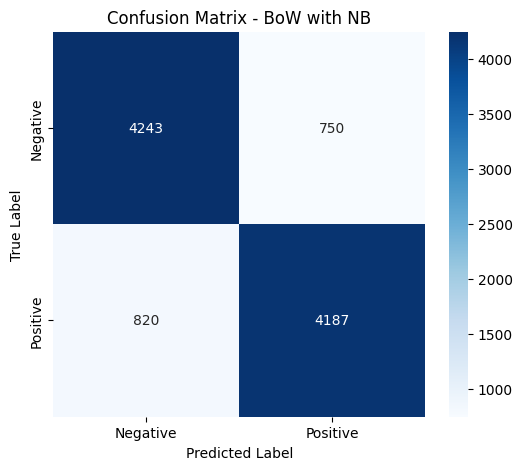

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Limiting to 5000 features for efficiency

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(train_reviews)
X_test_bow = vectorizer.transform(test_reviews)

# Convert sentiment labels to binary (positive -> 1, negative -> 0)
train_labels = train_sentiments.map({"positive": 1, "negative": 0})
test_labels = test_sentiments.map({"positive": 1, "negative": 0})

# Train Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_bow, train_labels)

# Predictions
y_pred = nb_classifier.predict(X_test_bow)

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
print(f"Naïve Bayes Accuracy with BoW: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(test_labels, y_pred))
# Confusion Matrix 
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BoW with NB")
plt.show()

In [11]:
# Identify misclassified examples
misclassified_indices_nb = (y_pred != test_labels).to_numpy().nonzero()[0]

# Print a few misclassified reviews
print("\nSample Misclassified Reviews:")
for idx in misclassified_indices_nb[:8]:  # Modify range as needed
    true_label = "positive" if test_labels.iloc[idx] == 1 else "negative"
    predicted_label = "positive" if y_pred[idx] == 1 else "negative"
    review_index = df['index'].iloc[40000 + idx]
    
    print(f"\nIndex: {review_index}")
    print(f"Original Review:\n{df['review'].iloc[40000 + idx]}")

    print(f"True Sentiment: {true_label}")
    print(f"Predicted Sentiment: {predicted_label}")
    print("-" * 80)



Sample Misclassified Reviews:

Index: 40018
Original Review:
This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an even madder father who wears a mask because of his horrible disfigurement, poisoning, spooky castles, werewolves (male and female), adultery, slain lovers, Tibetan mystics, the half-man/half-plant victim of some unnamed experiment, grave robbing, mind control, walled up bodies, a car crash on a lonely road, electrocution, knights in armour - the lot, all topped off with an incredibly awful score and some of the worst Foley work ever done.<br /><br />The script is incomprehensible (even by badly dubbed Spanish Horror movie standards) and some of the editing is just bizarre. In one scene where the lead female evil scientist goes to visit our heroine in her bedroom for one of the badly dubbed: "That is fantastical. I do not understand. Explain to me again how this is..." exposition s

In [12]:
import csv
# Prepare the misclassified DataFrame
misclassified_data = {
    "index": df["index"].iloc[40000 + misclassified_indices_nb].values,
    "original_review": df["review"].iloc[40000 + misclassified_indices_nb].values,
    "processed_review": df["processed_review"].iloc[40000 + misclassified_indices_nb].values,
    "true_sentiment": test_labels.iloc[misclassified_indices_nb].map({1: "positive", 0: "negative"}).values,
    "predicted_sentiment": pd.Series(y_pred[misclassified_indices_nb]).map({1: "positive", 0: "negative"}).values,
}

misclassified_df = pd.DataFrame(misclassified_data)

# Export to CSV
misclassified_df.to_csv("bow_nb.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)


1. WordCloud for misclassified reviews

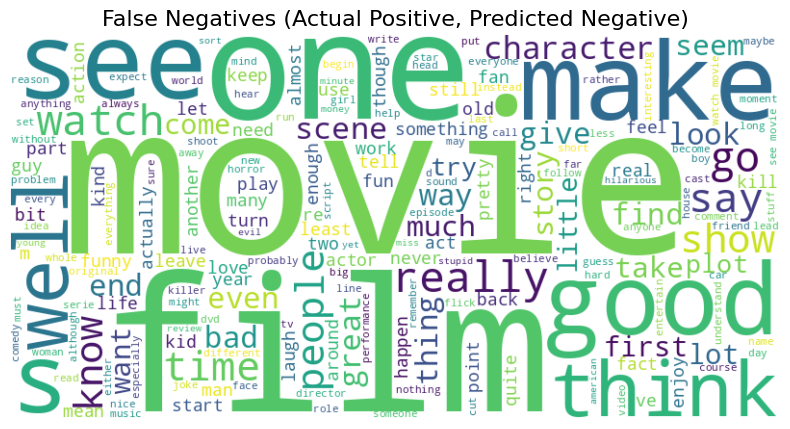

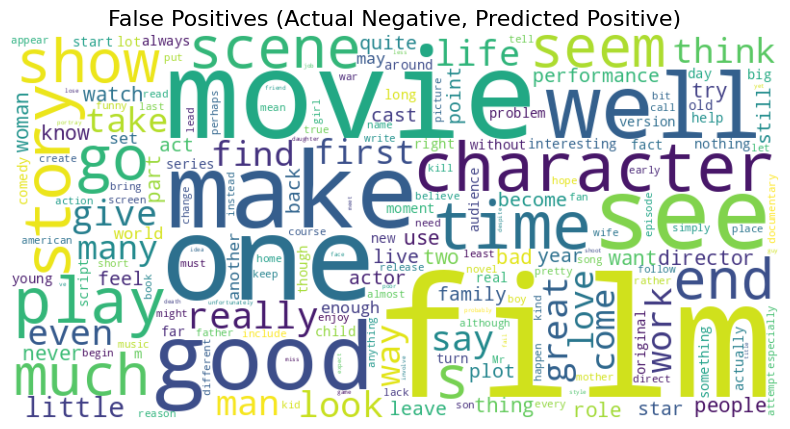

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split misclassified reviews by true sentiment
false_negatives = misclassified_df[misclassified_df["true_sentiment"] == "positive"]
false_positives = misclassified_df[misclassified_df["true_sentiment"] == "negative"]

# Generate word clouds
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Word cloud for false negatives
plot_wordcloud(false_negatives["processed_review"], "False Negatives (Actual Positive, Predicted Negative)")

# Word cloud for false positives
plot_wordcloud(false_positives["processed_review"], "False Positives (Actual Negative, Predicted Positive)")


2. Reviews with negations

In [14]:
# Check for negation words that could have confused the model
negation_words = ["not", "no", "never", "nothing", "wasn't", "didn't", "couldn't", "don't", "isn't"]

# Find misclassified reviews that contain negation words
contains_negation = misclassified_df[misclassified_df["processed_review"].str.contains(r'\b(?:' + '|'.join(negation_words) + r')\b')]

print(f"\n Misclassified reviews with negation words: {len(contains_negation)}")
display(contains_negation[["index", "original_review", "true_sentiment", "predicted_sentiment"]].head(5))



 Misclassified reviews with negation words: 1139


,index,original_review,true_sentiment,predicted_sentiment
0,40018,This movie is stuffed full of stock Horror mov...,positive,negative
1,40025,"I haven't seen BSG, I tried to watch it once i...",positive,negative
3,40043,"Office work, especially in this era of compute...",negative,positive
4,40054,There seems to be an overwhelming response to ...,negative,positive
5,40073,It was 1974 and it starred Martin Sheen.<br />...,negative,positive


3. Most Common Misleading Words

In [15]:
from collections import Counter

# Flatten all words from misclassified processed reviews
all_words = ' '.join(misclassified_df["processed_review"]).split()
common_words = Counter(all_words).most_common(20)

# Print common misleading words
print("Top 20 most frequent words in misclassified reviews:")
for word, freq in common_words:
    print(f"{word}: {freq}")


Top 20 most frequent words in misclassified reviews:
film: 2900
movie: 2719
not: 2270
one: 1558
like: 1409
see: 1384
do: 1349
make: 1241
good: 1163
get: 1114
well: 972
time: 829
go: 819
s: 805
would: 784
character: 755
watch: 751
really: 732
think: 715
story: 674


## BoW with LR

Logistic Regression Accuracy with BoW: 0.8732

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      4993
           1       0.87      0.87      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



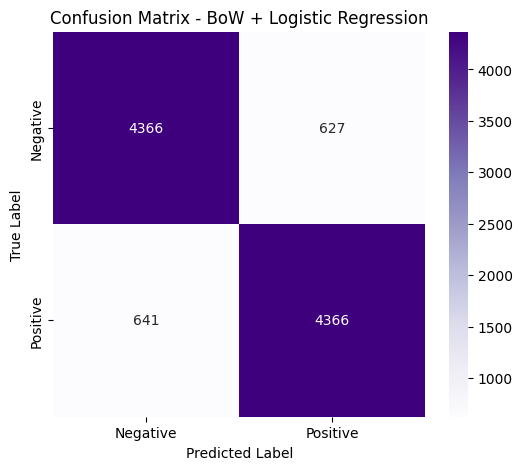

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Limiting to 5000 features for efficiency

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(train_reviews)
X_test_bow = vectorizer.transform(test_reviews)

# Convert sentiment labels to binary (positive -> 1, negative -> 0)
train_labels = train_sentiments.map({"positive": 1, "negative": 0})
test_labels = test_sentiments.map({"positive": 1, "negative": 0})

# Train Logistic Regression
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train_bow, train_labels)

# Predict
y_pred_lr = lr_classifier.predict(X_test_bow)

# Evaluate
accuracy_lr = accuracy_score(test_labels, y_pred_lr)
print(f"Logistic Regression Accuracy with BoW: {accuracy_lr:.4f}")
print("\nClassification Report:\n", classification_report(test_labels, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(test_labels, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BoW + Logistic Regression")
plt.show()


In [17]:
# Get misclassified indices for LR
misclassified_indices_lr = (y_pred_lr != test_labels.to_numpy()).nonzero()[0]

print("\nSample Misclassified Reviews (Logistic Regression):")
for idx in misclassified_indices_lr[:8]:  
    print(f"\nOriginal Review:\n{df['review'].iloc[40000 + idx]}")
    print(f"True Sentiment: {test_labels.iloc[idx]}")
    print(f"Predicted Sentiment: {y_pred_lr[idx]}")



Sample Misclassified Reviews (Logistic Regression):

Original Review:
This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an even madder father who wears a mask because of his horrible disfigurement, poisoning, spooky castles, werewolves (male and female), adultery, slain lovers, Tibetan mystics, the half-man/half-plant victim of some unnamed experiment, grave robbing, mind control, walled up bodies, a car crash on a lonely road, electrocution, knights in armour - the lot, all topped off with an incredibly awful score and some of the worst Foley work ever done.<br /><br />The script is incomprehensible (even by badly dubbed Spanish Horror movie standards) and some of the editing is just bizarre. In one scene where the lead female evil scientist goes to visit our heroine in her bedroom for one of the badly dubbed: "That is fantastical. I do not understand. Explain to me again how this is..." exp

In [18]:
# Create a DataFrame of misclassified reviews
misclassified_lr_df = pd.DataFrame({
    "index": df["index"].iloc[40000 + misclassified_indices_lr].values,
    "original_review": df["review"].iloc[40000 + misclassified_indices_lr].values,
    "processed_review": df["processed_review"].iloc[40000 + misclassified_indices_lr].values,
    "true_sentiment": test_labels.iloc[misclassified_indices_lr].values,
    "predicted_sentiment": y_pred_lr[misclassified_indices_lr]
})

# Save to CSV
misclassified_lr_df.to_csv("bow_lr.csv", index=False)


COMPARING BOTH MODELS' MISCLASSIFIED REVIEWS

In [19]:

# Get indices (within test set) of NB and LR misclassifications
misclassified_set_nb = set(misclassified_indices_nb)
misclassified_set_lr = set(misclassified_indices_lr)

# Compare
common_misclassified = misclassified_set_nb & misclassified_set_lr
only_nb = misclassified_set_nb - misclassified_set_lr
only_lr = misclassified_set_lr - misclassified_set_nb

print(f"\nCommon Misclassified Reviews (NB & LR): {len(common_misclassified)}")
print(f"Misclassified only by NB: {len(only_nb)}")
print(f"Misclassified only by LR: {len(only_lr)}")



Common Misclassified Reviews (NB & LR): 733
Misclassified only by NB: 837
Misclassified only by LR: 535


In [20]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Load misclassified reviews for BoW+NB and BoW+LR
bow_nb_df = pd.read_csv("bow_nb.csv")
bow_lr_df = pd.read_csv("bow_lr.csv")

# Add tag to each
bow_nb_df["misclassified_by"] = "NB"
bow_lr_df["misclassified_by"] = "LR"

# Merge into one DataFrame
bow_merged = pd.concat([bow_nb_df, bow_lr_df], ignore_index=True)

# Group by index
bow_grouped = bow_merged.groupby("index").agg({
    "original_review": "first",
    "true_sentiment": "first",
    "predicted_sentiment": lambda x: list(x),
    "misclassified_by": lambda x: list(x)
}).reset_index()

# Grouping into different categories
bow_misclassified_both = bow_grouped[bow_grouped["misclassified_by"].apply(lambda x: set(x) == {"NB", "LR"})]
bow_misclassified_one = bow_grouped[bow_grouped["misclassified_by"].apply(lambda x: len(x) == 1)]

# Display
print("Misclassified by BOTH NB and LR (BoW):")
display(bow_misclassified_both.head(10))

print("Misclassified by ONLY ONE of NB or LR (BoW):")
display(bow_misclassified_one.head(10))


Misclassified by BOTH NB and LR (BoW):


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
0,40018,This movie is stuffed full of stock Horror mov...,positive,"[negative, 0]","[NB, LR]"
4,40039,This must rank as one of Cinema's greatest deb...,negative,"[positive, 1]","[NB, LR]"
5,40043,"Office work, especially in this era of compute...",negative,"[positive, 1]","[NB, LR]"
11,40089,Cutting to the chase: This is one of the most ...,positive,"[negative, 0]","[NB, LR]"
12,40091,"Still a sucker for Pyun's esthetic sense, I li...",negative,"[positive, 1]","[NB, LR]"
13,40099,This film suffers horrendously from its direct...,negative,"[positive, 1]","[NB, LR]"
15,40102,"This is basically a goofball comedy, with some...",positive,"[negative, 0]","[NB, LR]"
16,40114,I thought that this film was very enjoyable. I...,positive,"[negative, 0]","[NB, LR]"
21,40134,"Let's face it, lot's of bad movies are made al...",positive,"[negative, 0]","[NB, LR]"
22,40139,"""Black Vengeance"" is an alternate title for ""Y...",negative,"[positive, 1]","[NB, LR]"


Misclassified by ONLY ONE of NB or LR (BoW):


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
1,40025,"I haven't seen BSG, I tried to watch it once i...",positive,[negative],[NB]
2,40026,"Well, it turned out as I expected: visual over...",0,[1],[LR]
3,40033,This two-part TV mini-series isn't as good as ...,1,[0],[LR]
6,40054,There seems to be an overwhelming response to ...,negative,[positive],[NB]
7,40057,I admit I had some trepidation when I first sa...,1,[0],[LR]
8,40073,It was 1974 and it starred Martin Sheen.<br />...,negative,[positive],[NB]
9,40079,First things first! This isn't an action movie...,positive,[negative],[NB]
10,40088,The good thing about this film is that it stan...,1,[0],[LR]
14,40100,Some people don't like the animation. Personal...,0,[1],[LR]
17,40116,Your mind will not be satisfied by this nobud...,negative,[positive],[NB]


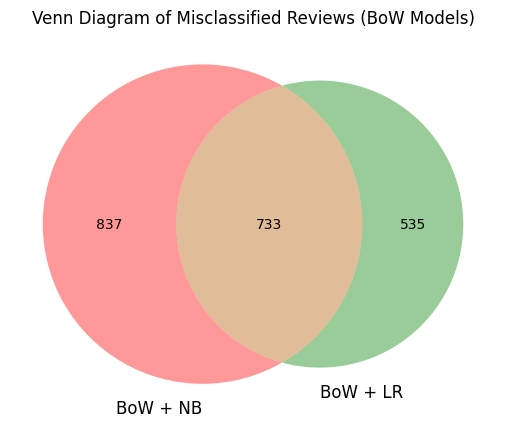

In [21]:
# Sets of misclassified review indices
nb_bow_indices = set(bow_nb_df["index"])
lr_bow_indices = set(bow_lr_df["index"])

# Venn diagram
plt.figure(figsize=(7, 5))
venn2(
    [nb_bow_indices, lr_bow_indices],
    set_labels=("BoW + NB", "BoW + LR")
)
plt.title("Venn Diagram of Misclassified Reviews (BoW Models)")
plt.show()


## TF-IDF with NB

Naïve Bayes Accuracy with TF-IDF: 0.8528

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4993
           1       0.85      0.86      0.85      5007

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



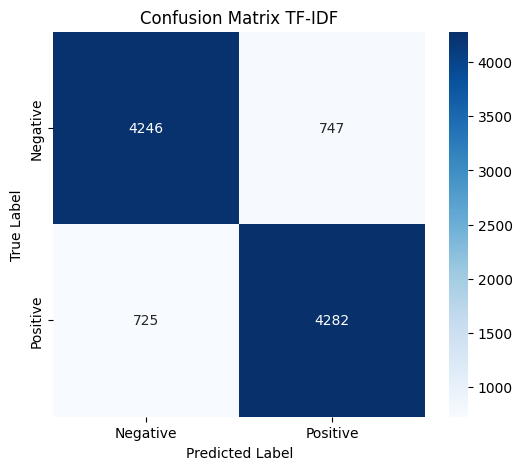

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with unigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=5000)

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_reviews)
X_test_tfidf = tfidf_vectorizer.transform(test_reviews)

# Train Naïve Bayes classifier with TF-IDF
nb_classifier_tfidf = MultinomialNB()
nb_classifier_tfidf.fit(X_train_tfidf, train_labels)

# Predictions
y_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf)

# Evaluate performance
accuracy_tfidf = accuracy_score(test_labels, y_pred_tfidf)
print(f"Naïve Bayes Accuracy with TF-IDF: {accuracy_tfidf:.4f}")
print("\nClassification Report:\n", classification_report(test_labels, y_pred_tfidf))

# Confusion Matrix for TF-IDF Model
cm_tfidf = confusion_matrix(test_labels, y_pred_tfidf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix TF-IDF")
plt.show()


In [23]:
# Identify misclassified indices
misclassified_indices_tfidf = (y_pred_tfidf != test_labels.to_numpy()).nonzero()[0]

print("\nSample Misclassified Reviews (TF-IDF + NB):")
for idx in misclassified_indices_tfidf[:8]:
    print(f"\nOriginal Review:\n{df['review'].iloc[40000 + idx]}")
    print(f"True Sentiment: {test_labels.iloc[idx]}")
    print(f"Predicted Sentiment: {y_pred_tfidf[idx]}")



Sample Misclassified Reviews (TF-IDF + NB):

Original Review:
This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an even madder father who wears a mask because of his horrible disfigurement, poisoning, spooky castles, werewolves (male and female), adultery, slain lovers, Tibetan mystics, the half-man/half-plant victim of some unnamed experiment, grave robbing, mind control, walled up bodies, a car crash on a lonely road, electrocution, knights in armour - the lot, all topped off with an incredibly awful score and some of the worst Foley work ever done.<br /><br />The script is incomprehensible (even by badly dubbed Spanish Horror movie standards) and some of the editing is just bizarre. In one scene where the lead female evil scientist goes to visit our heroine in her bedroom for one of the badly dubbed: "That is fantastical. I do not understand. Explain to me again how this is..." exposition 

In [24]:
# Create a DataFrame of misclassified reviews
misclassified_tfidf_df = pd.DataFrame({
    "index": df["index"].iloc[40000 + misclassified_indices_tfidf].values,
    "original_review": df["review"].iloc[40000 + misclassified_indices_tfidf].values,
    "processed_review": df["processed_review"].iloc[40000 + misclassified_indices_tfidf].values,
    "true_sentiment": test_labels.iloc[misclassified_indices_tfidf].values,
    "predicted_sentiment": y_pred_tfidf[misclassified_indices_tfidf]
})

# Export to CSV
misclassified_tfidf_df.to_csv("misclassified_reviews_tfidf_nb.csv", index=False)


1. WordCloud of misclassified reviews

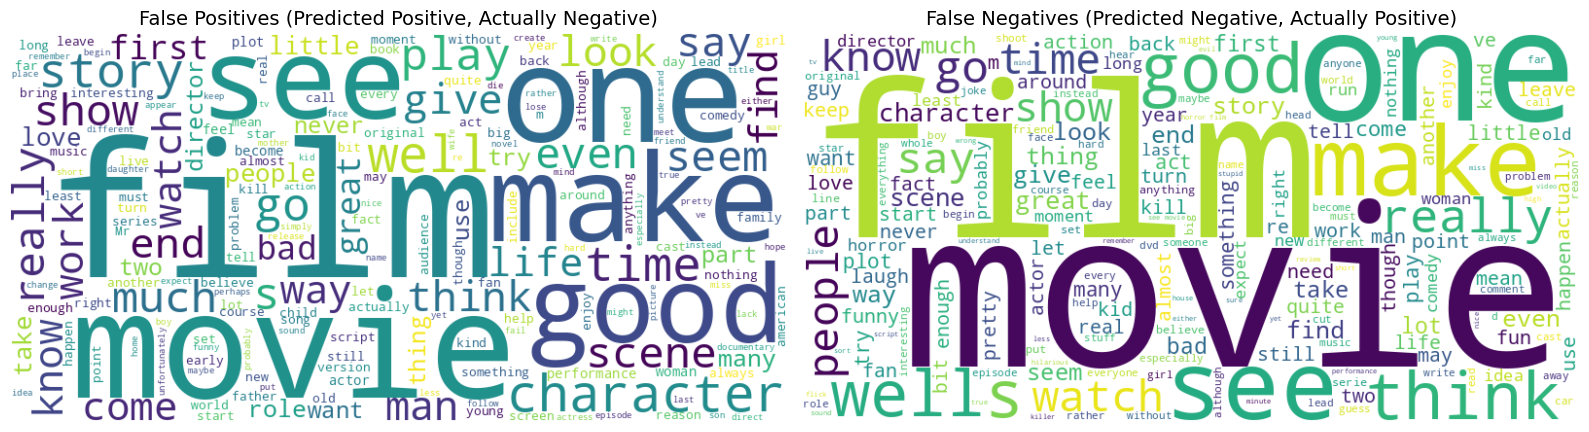

In [25]:
# Convert labels to NumPy arrays
true_labels = test_labels.to_numpy()
predicted_labels = y_pred_tfidf

# Indices for false positives and false negatives
false_positive_indices = [i for i in range(len(true_labels)) if predicted_labels[i] == 1 and true_labels[i] == 0]
false_negative_indices = [i for i in range(len(true_labels)) if predicted_labels[i] == 0 and true_labels[i] == 1]

# Get processed reviews for each case
fp_reviews = df["processed_review"].iloc[40000 + pd.Series(false_positive_indices)]
fn_reviews = df["processed_review"].iloc[40000 + pd.Series(false_negative_indices)]

# Combine reviews into strings
fp_text = " ".join(fp_reviews)
fn_text = " ".join(fn_reviews)

# Generate wordclouds
wordcloud_fp = WordCloud(width=800, height=400, background_color='white').generate(fp_text)
wordcloud_fn = WordCloud(width=800, height=400, background_color='white').generate(fn_text)

# Plot side-by-side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fp, interpolation='bilinear')
plt.title("False Positives (Predicted Positive, Actually Negative)", fontsize=14)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.title("False Negatives (Predicted Negative, Actually Positive)", fontsize=14)
plt.axis("off")

plt.tight_layout()
plt.show()


2. Reviews with Negations

In [26]:
# Define negation terms
negation_terms = ["not", "no", "never", "n't"]

print("\nReviews with Negation (TF-IDF Misclassified):\n")
count = 0
for idx, row in misclassified_tfidf_df.iterrows():
    if any(term in row['processed_review'].lower().split() for term in negation_terms):
        print(f"Review #{row['index']}:")
        print(f"Original Review:\n{row['original_review']}")
        print(f"True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']}\n{'-'*80}")
        count += 1
    if count >= 5:
        break



Reviews with Negation (TF-IDF Misclassified):

Review #40018:
Original Review:
This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an even madder father who wears a mask because of his horrible disfigurement, poisoning, spooky castles, werewolves (male and female), adultery, slain lovers, Tibetan mystics, the half-man/half-plant victim of some unnamed experiment, grave robbing, mind control, walled up bodies, a car crash on a lonely road, electrocution, knights in armour - the lot, all topped off with an incredibly awful score and some of the worst Foley work ever done.<br /><br />The script is incomprehensible (even by badly dubbed Spanish Horror movie standards) and some of the editing is just bizarre. In one scene where the lead female evil scientist goes to visit our heroine in her bedroom for one of the badly dubbed: "That is fantastical. I do not understand. Explain to me again how this i

3. Most Common Misleading Words

In [27]:

# Step 1: Create CountVectorizer
cv = CountVectorizer(max_features=1000)

# Step 2: FP — Most common misleading words
X_fp = cv.fit_transform(fp_reviews)
sum_words_fp = X_fp.sum(axis=0)
fp_words_freq = [(word, sum_words_fp[0, idx]) for word, idx in cv.vocabulary_.items()]
fp_words_freq = sorted(fp_words_freq, key=lambda x: x[1], reverse=True)

print("\nTop 15 Words in False Positives (Predicted Positive, Actually Negative):")
for word, freq in fp_words_freq[:15]:
    print(f"{word}: {freq}")

# Step 3: FN — Most common misleading words
cv = CountVectorizer(max_features=1000)  # reinitialize to reset vocabulary
X_fn = cv.fit_transform(fn_reviews)
sum_words_fn = X_fn.sum(axis=0)
fn_words_freq = [(word, sum_words_fn[0, idx]) for word, idx in cv.vocabulary_.items()]
fn_words_freq = sorted(fn_words_freq, key=lambda x: x[1], reverse=True)

print("\nTop 15 Words in False Negatives (Predicted Negative, Actually Positive):")
for word, freq in fn_words_freq[:15]:
    print(f"{word}: {freq}")



Top 15 Words in False Positives (Predicted Positive, Actually Negative):
film: 1562
movie: 964
not: 937
one: 769
make: 614
see: 585
like: 569
do: 561
good: 481
well: 451
character: 438
would: 437
get: 432
story: 403
time: 387

Top 15 Words in False Negatives (Predicted Negative, Actually Positive):
movie: 1573
film: 1299
not: 1209
like: 776
one: 752
see: 723
do: 719
get: 638
good: 635
make: 575
well: 467
think: 435
watch: 434
go: 427
really: 410


Logistic Regression Accuracy: 0.8833

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4993
           1       0.88      0.89      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



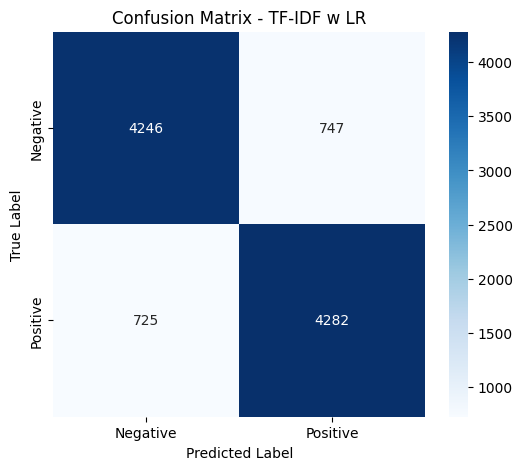

In [28]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train_tfidf, train_labels)

# Make Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
# Evaluate Performance
print("Logistic Regression Accuracy:", accuracy_score(test_labels, y_pred_lr))
print("\nClassification Report:\n", classification_report(test_labels, y_pred_lr))

# Confusion Matrix for TF-IDF Model
cm_tfidf_lr = confusion_matrix(test_labels, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TF-IDF w LR")
plt.show()

## TFIDF WITH SVM


Evaluating SVM with kernel: linear
Accuracy (linear): 0.8829

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4993
           1       0.88      0.88      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



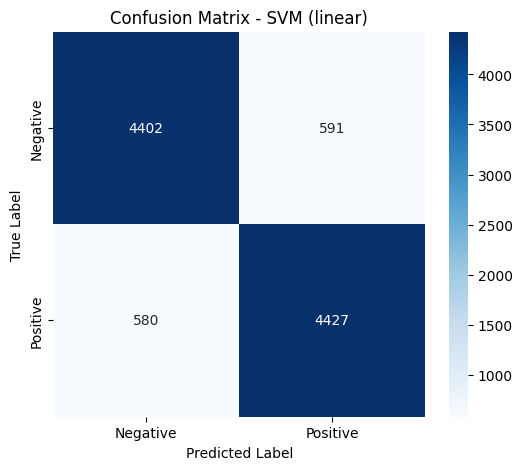

Misclassified reviews saved as: misclassified_reviews_tfidf_svm_linear.csv

Evaluating SVM with kernel: rbf
Accuracy (rbf): 0.8862

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      4993
           1       0.88      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



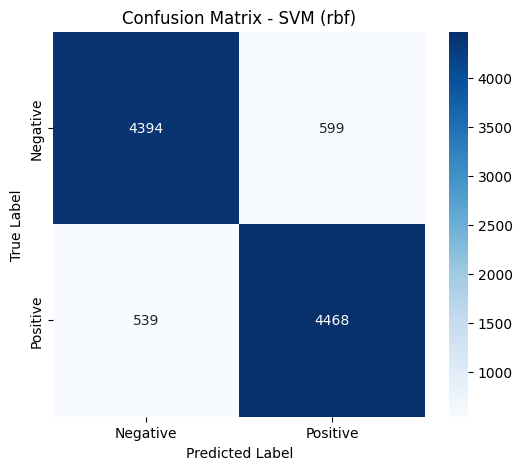

Misclassified reviews saved as: misclassified_reviews_tfidf_svm_rbf.csv

Evaluating SVM with kernel: poly
Accuracy (poly): 0.8676

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      4993
           1       0.84      0.91      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



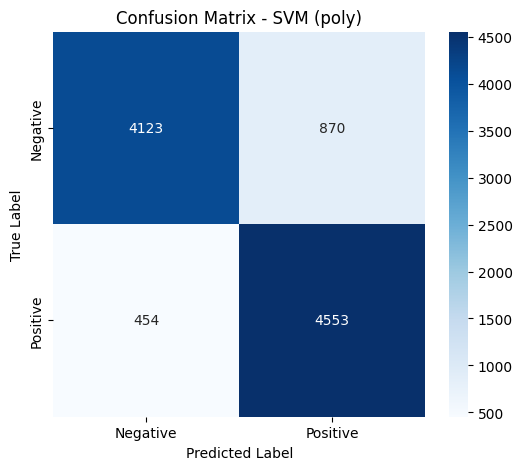

Misclassified reviews saved as: misclassified_reviews_tfidf_svm_poly.csv

Evaluating SVM with kernel: sigmoid
Accuracy (sigmoid): 0.8811

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4993
           1       0.88      0.88      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



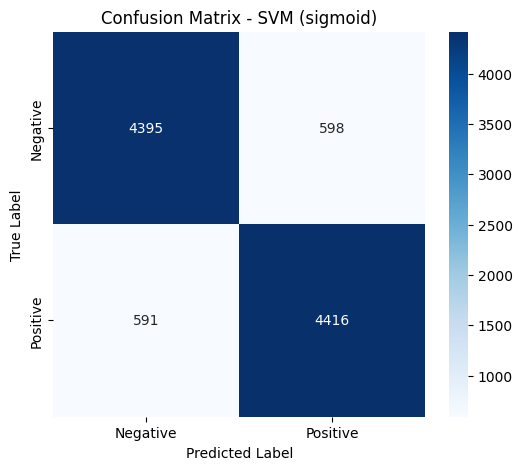

Misclassified reviews saved as: misclassified_reviews_tfidf_svm_sigmoid.csv


In [29]:
from sklearn.svm import SVC

def evaluate_svm_kernel(kernel_name):
    print(f"\n{'='*30}\nEvaluating SVM with kernel: {kernel_name}\n{'='*30}")
    
    svm_model = SVC(kernel=kernel_name)
    svm_model.fit(X_train_tfidf, train_labels)
    
    y_pred = svm_model.predict(X_test_tfidf)
    
    # Accuracy & Report
    accuracy = accuracy_score(test_labels, y_pred)
    print(f"Accuracy ({kernel_name}): {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(test_labels, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - SVM ({kernel_name})")
    plt.show()
    
    # Misclassified Review Export
    misclassified_indices = (y_pred != test_labels.to_numpy()).nonzero()[0]
    misclassified_df = pd.DataFrame({
        "index": df["index"].iloc[40000 + pd.Series(misclassified_indices)].values,
        "original_review": df["review"].iloc[40000 + pd.Series(misclassified_indices)].values,
        "processed_review": df["processed_review"].iloc[40000 + pd.Series(misclassified_indices)].values,
        "true_sentiment": test_labels.iloc[misclassified_indices].map({1: "positive", 0: "negative"}).values,
        "predicted_sentiment": [ "positive" if pred == 1 else "negative" for pred in y_pred[misclassified_indices] ]
    })
    
    misclassified_df.to_csv(f"misclassified_reviews_tfidf_svm_{kernel_name}.csv", index=False)
    print(f"Misclassified reviews saved as: misclassified_reviews_tfidf_svm_{kernel_name}.csv")

kernels = ["linear", "rbf", "poly", "sigmoid"]
for k in kernels:
    evaluate_svm_kernel(k)


In [30]:
# Load misclassified review CSV from linear kernel SVM
import pandas as pd

misclassified_svm_df = pd.read_csv("misclassified_reviews_tfidf_svm_rbf.csv")

# Print 8 sample misclassified reviews
print("\nSample Misclassified Reviews - TF-IDF + SVM (RBF):")
for i in range(min(8, len(misclassified_svm_df))):
    row = misclassified_svm_df.iloc[i]
    print(f"\nReview #{row['index']}")
    print(f"Original Review:\n{row['original_review']}")
    print(f"True Sentiment: {row['true_sentiment']} | Predicted Sentiment: {row['predicted_sentiment']}")
    print("-" * 80)



Sample Misclassified Reviews - TF-IDF + SVM (RBF):

Review #40018
Original Review:
This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an even madder father who wears a mask because of his horrible disfigurement, poisoning, spooky castles, werewolves (male and female), adultery, slain lovers, Tibetan mystics, the half-man/half-plant victim of some unnamed experiment, grave robbing, mind control, walled up bodies, a car crash on a lonely road, electrocution, knights in armour - the lot, all topped off with an incredibly awful score and some of the worst Foley work ever done.<br /><br />The script is incomprehensible (even by badly dubbed Spanish Horror movie standards) and some of the editing is just bizarre. In one scene where the lead female evil scientist goes to visit our heroine in her bedroom for one of the badly dubbed: "That is fantastical. I do not understand. Explain to me again how th

## TFIDF WITH LR

Logistic Regression Accuracy with TF-IDF: 0.8833

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4993
           1       0.88      0.89      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



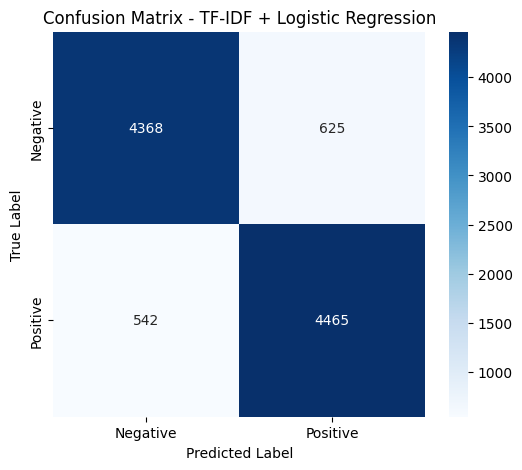

In [31]:
from sklearn.linear_model import LogisticRegression
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, train_labels)

# Predict
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate
accuracy_lr = accuracy_score(test_labels, y_pred_lr)
print(f"Logistic Regression Accuracy with TF-IDF: {accuracy_lr:.4f}")
print("\nClassification Report:\n", classification_report(test_labels, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(test_labels, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()


In [32]:
# Get misclassified indices
misclassified_indices_lr = (y_pred_lr != test_labels.to_numpy()).nonzero()[0]

# Create misclassified DataFrame
misclassified_lr_df = pd.DataFrame({
    "index": df["index"].iloc[40000 + pd.Series(misclassified_indices_lr)].values,
    "original_review": df["review"].iloc[40000 + pd.Series(misclassified_indices_lr)].values,
    "processed_review": df["processed_review"].iloc[40000 + pd.Series(misclassified_indices_lr)].values,
    "true_sentiment": test_labels.iloc[misclassified_indices_lr].map({1: "positive", 0: "negative"}).values,
    "predicted_sentiment": [ "positive" if pred == 1 else "negative" for pred in y_pred_lr[misclassified_indices_lr] ]
})

# Export to CSV
misclassified_lr_df.to_csv("tfidf_lr.csv", index=False)
print(" Misclassified reviews for TF-IDF + LR saved to CSV.")


 Misclassified reviews for TF-IDF + LR saved to CSV.


In [33]:
print("\nSample Misclassified Reviews - TF-IDF + LR:")
for i in range(8):
    row = misclassified_lr_df.iloc[i]
    print(f"\nReview #{row['index']}")
    print(f"Original Review:\n{row['original_review']}")
    print(f"True Sentiment: {row['true_sentiment']} | Predicted Sentiment: {row['predicted_sentiment']}")


Sample Misclassified Reviews - TF-IDF + LR:

Review #40018
Original Review:
This movie is stuffed full of stock Horror movie goodies: chained lunatics, pre-meditated murder, a mad (vaguely lesbian) female scientist with an even madder father who wears a mask because of his horrible disfigurement, poisoning, spooky castles, werewolves (male and female), adultery, slain lovers, Tibetan mystics, the half-man/half-plant victim of some unnamed experiment, grave robbing, mind control, walled up bodies, a car crash on a lonely road, electrocution, knights in armour - the lot, all topped off with an incredibly awful score and some of the worst Foley work ever done.<br /><br />The script is incomprehensible (even by badly dubbed Spanish Horror movie standards) and some of the editing is just bizarre. In one scene where the lead female evil scientist goes to visit our heroine in her bedroom for one of the badly dubbed: "That is fantastical. I do not understand. Explain to me again how this is..

COMPARING ALL TFIDF MODELS

In [34]:

# Get indices (within test set) of NB and LR misclassifications
misclassified_set_nb = set(misclassified_indices_nb)
misclassified_set_lr = set(misclassified_indices_lr)

# Compare
common_misclassified = misclassified_set_nb & misclassified_set_lr
only_nb = misclassified_set_nb - misclassified_set_lr
only_lr = misclassified_set_lr - misclassified_set_nb

print(f"\nCommon Misclassified Reviews (NB & LR): {len(common_misclassified)}")
print(f"Misclassified only by NB: {len(only_nb)}")
print(f"Misclassified only by LR: {len(only_lr)}")



Common Misclassified Reviews (NB & LR): 862
Misclassified only by NB: 708
Misclassified only by LR: 305


In [35]:
import pandas as pd

# Load the saved CSVs
nb_df = pd.read_csv("misclassified_reviews_tfidf_nb.csv")
svm_df = pd.read_csv("misclassified_reviews_tfidf_svm_linear.csv")
lr_df = pd.read_csv("tfidf_lr.csv")

# Add tags for which model misclassified
nb_df["misclassified_by"] = "NB"
svm_df["misclassified_by"] = "SVM"
lr_df["misclassified_by"] = "LR"

# Combine into one DataFrame
merged = pd.concat([nb_df, svm_df, lr_df], ignore_index=True)

# Group by index to track overlaps
grouped = merged.groupby("index").agg({
    "original_review": "first",
    "true_sentiment": "first",
    "predicted_sentiment": lambda x: list(x),
    "misclassified_by": lambda x: list(x)
}).reset_index()

# Grouped comparisons
misclassified_all = grouped[grouped["misclassified_by"].apply(lambda x: set(x) == {"NB", "SVM", "LR"})]
misclassified_one = grouped[grouped["misclassified_by"].apply(lambda x: len(x) == 1)]
misclassified_two = grouped[grouped["misclassified_by"].apply(lambda x: len(x) == 2)]

# Display as separate DataFrames
print(" Misclassified by ALL 3 Models:")
display(misclassified_all.head(10))  # Show top 10 rows

print(" Misclassified by ONLY ONE Model:")
display(misclassified_one.head(10))

print(" Misclassified by EXACTLY TWO Models:")
display(misclassified_two.head(10))


 Misclassified by ALL 3 Models:


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
0,40018,This movie is stuffed full of stock Horror mov...,1,"[0, negative, negative]","[NB, SVM, LR]"
3,40039,This must rank as one of Cinema's greatest deb...,0,"[1, positive, positive]","[NB, SVM, LR]"
4,40043,"Office work, especially in this era of compute...",0,"[1, positive, positive]","[NB, SVM, LR]"
12,40089,Cutting to the chase: This is one of the most ...,1,"[0, negative, negative]","[NB, SVM, LR]"
13,40091,"Still a sucker for Pyun's esthetic sense, I li...",0,"[1, positive, positive]","[NB, SVM, LR]"
14,40099,This film suffers horrendously from its direct...,0,"[1, positive, positive]","[NB, SVM, LR]"
17,40114,I thought that this film was very enjoyable. I...,1,"[0, negative, negative]","[NB, SVM, LR]"
18,40116,Your mind will not be satisfied by this nobud...,0,"[1, positive, positive]","[NB, SVM, LR]"
20,40139,"""Black Vengeance"" is an alternate title for ""Y...",0,"[1, positive, positive]","[NB, SVM, LR]"
23,40146,A horror movie is being shot and things aren't...,1,"[0, negative, negative]","[NB, SVM, LR]"


 Misclassified by ONLY ONE Model:


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
2,40033,This two-part TV mini-series isn't as good as ...,positive,[negative],[LR]
5,40048,It Could Have Been A Marvelous Story Based On ...,0,[1],[NB]
6,40052,As much as I love Ellen Barkin (who is really ...,negative,[positive],[SVM]
7,40054,There seems to be an overwhelming response to ...,0,[1],[NB]
9,40073,It was 1974 and it starred Martin Sheen.<br />...,0,[1],[NB]
16,40102,"This is basically a goofball comedy, with some...",1,[0],[NB]
22,40143,While the original First Blood had its far-fet...,0,[1],[NB]
27,40159,"As this movie is completely in Swiss dialect, ...",1,[0],[NB]
31,40178,Jochen Hick wrote and directed this little thr...,0,[1],[NB]
32,40182,"I couldn't agree more with the other comment, ...",1,[0],[NB]


 Misclassified by EXACTLY TWO Models:


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
1,40024,"I wasn't really interested in seeing Step Up, ...",negative,"[positive, positive]","[SVM, LR]"
8,40057,I admit I had some trepidation when I first sa...,positive,"[negative, negative]","[SVM, LR]"
10,40080,In my review just submitted I referred to the ...,positive,"[negative, negative]","[SVM, LR]"
11,40088,The good thing about this film is that it stan...,positive,"[negative, negative]","[SVM, LR]"
15,40100,Some people don't like the animation. Personal...,negative,"[positive, positive]","[SVM, LR]"
19,40134,"Let's face it, lot's of bad movies are made al...",1,"[0, negative]","[NB, SVM]"
21,40141,"I throughly enjoyed this short, even as a Toro...",positive,"[negative, negative]","[SVM, LR]"
29,40172,Not a terrible movie... But there are monster ...,negative,"[positive, positive]","[SVM, LR]"
30,40177,I saw this on a cheap DVD release with the tit...,negative,"[positive, positive]","[SVM, LR]"
38,40215,So so special effects get in the way of recapt...,0,"[1, positive]","[NB, SVM]"


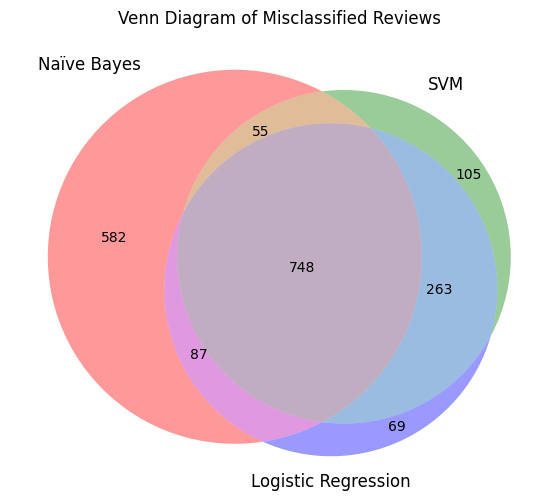

In [36]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Get sets of indices for each model's misclassified reviews
nb_indices = set(nb_df["index"])
svm_indices = set(svm_df["index"])
lr_indices = set(lr_df["index"])

# Plot Venn diagram
plt.figure(figsize=(8, 6))
venn3(
    [nb_indices, svm_indices, lr_indices],
    set_labels=("Naïve Bayes", "SVM", "Logistic Regression")
)
plt.title("Venn Diagram of Misclassified Reviews")
plt.show()


COMPARING MISCLASSIFIED REVIEWS OF BOW AND TFIDF

 Misclassified by BOTH (BoW+LR and TF-IDF+SVM RBF):


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
0,40018,This movie is stuffed full of stock Horror mov...,1,"[0, negative]","[BoW+LR, TF-IDF+SVM_RBF]"
4,40039,This must rank as one of Cinema's greatest deb...,0,"[1, positive]","[BoW+LR, TF-IDF+SVM_RBF]"
5,40043,"Office work, especially in this era of compute...",0,"[1, positive]","[BoW+LR, TF-IDF+SVM_RBF]"
6,40057,I admit I had some trepidation when I first sa...,1,"[0, negative]","[BoW+LR, TF-IDF+SVM_RBF]"
8,40088,The good thing about this film is that it stan...,1,"[0, negative]","[BoW+LR, TF-IDF+SVM_RBF]"
9,40089,Cutting to the chase: This is one of the most ...,1,"[0, negative]","[BoW+LR, TF-IDF+SVM_RBF]"
10,40091,"Still a sucker for Pyun's esthetic sense, I li...",0,"[1, positive]","[BoW+LR, TF-IDF+SVM_RBF]"
11,40099,This film suffers horrendously from its direct...,0,"[1, positive]","[BoW+LR, TF-IDF+SVM_RBF]"
12,40100,Some people don't like the animation. Personal...,0,"[1, positive]","[BoW+LR, TF-IDF+SVM_RBF]"
14,40114,I thought that this film was very enjoyable. I...,1,"[0, negative]","[BoW+LR, TF-IDF+SVM_RBF]"



 Misclassified by ONLY ONE model:


,index,original_review,true_sentiment,predicted_sentiment,misclassified_by
1,40024,"I wasn't really interested in seeing Step Up, ...",negative,[positive],[TF-IDF+SVM_RBF]
2,40026,"Well, it turned out as I expected: visual over...",0,[1],[BoW+LR]
3,40033,This two-part TV mini-series isn't as good as ...,1,[0],[BoW+LR]
7,40080,In my review just submitted I referred to the ...,positive,[negative],[TF-IDF+SVM_RBF]
13,40102,"This is basically a goofball comedy, with some...",1,[0],[BoW+LR]
15,40116,Your mind will not be satisfied by this nobud...,negative,[positive],[TF-IDF+SVM_RBF]
16,40119,I am really surprised that this film only has ...,1,[0],[BoW+LR]
17,40120,"The Late Shift is a great book, I read the boo...",1,[0],[BoW+LR]
23,40152,"To begin with, I really love Lucy. Her TV show...",negative,[positive],[TF-IDF+SVM_RBF]
27,40177,I saw this on a cheap DVD release with the tit...,0,[1],[BoW+LR]


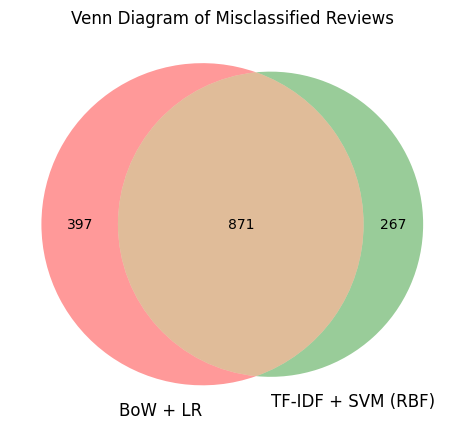

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Load misclassified reviews
bow_lr_df = pd.read_csv("bow_lr.csv")
tfidf_svm_rbf_df = pd.read_csv("misclassified_reviews_tfidf_svm_rbf.csv")

# Add a column to identify the model that misclassified it
bow_lr_df["misclassified_by"] = "BoW+LR"
tfidf_svm_rbf_df["misclassified_by"] = "TF-IDF+SVM_RBF"

# Combine both DataFrames
combined_df = pd.concat([bow_lr_df, tfidf_svm_rbf_df], ignore_index=True)

# Group by review index
grouped = combined_df.groupby("index").agg({
    "original_review": "first",
    "true_sentiment": "first",
    "predicted_sentiment": lambda x: list(x),
    "misclassified_by": lambda x: list(x)
}).reset_index()

# Separate categories
misclassified_by_both = grouped[grouped["misclassified_by"].apply(lambda x: set(x) == {"BoW+LR", "TF-IDF+SVM_RBF"})]
misclassified_by_one = grouped[grouped["misclassified_by"].apply(lambda x: len(x) == 1)]

# Display
print(" Misclassified by BOTH (BoW+LR and TF-IDF+SVM RBF):")
display(misclassified_by_both.head(10))

print("\n Misclassified by ONLY ONE model:")
display(misclassified_by_one.head(10))

# Sets of misclassified indices for Venn diagram
bow_lr_indices = set(bow_lr_df["index"])
svm_rbf_indices = set(tfidf_svm_rbf_df["index"])

# Venn diagram
plt.figure(figsize=(7, 5))
venn2(
    [bow_lr_indices, svm_rbf_indices],
    set_labels=("BoW + LR", "TF-IDF + SVM (RBF)")
)
plt.title("Venn Diagram of Misclassified Reviews")
plt.show()


In [38]:
# Load misclassified reviews
bow_lr_df = pd.read_csv("bow_lr.csv")
svm_rbf_df = pd.read_csv("misclassified_reviews_tfidf_svm_rbf.csv")

# Get misclassified indices
bow_misclassified = set(bow_lr_df["index"])
svm_rbf_misclassified = set(svm_rbf_df["index"])

# All test indices (i.e., original dataset index from 40000 to 49999)
test_indices = set(df["index"].iloc[40000:])

# ✅ Correctly classified by BoW + LR but misclassified by TF-IDF + SVM
bow_correct_svm_wrong = test_indices - bow_misclassified
bow_correct_svm_wrong = bow_correct_svm_wrong & svm_rbf_misclassified

# ✅ Correctly classified by TF-IDF + SVM but misclassified by BoW + LR
svm_correct_bow_wrong = test_indices - svm_rbf_misclassified
svm_correct_bow_wrong = svm_correct_bow_wrong & bow_misclassified

# Display examples
print("✅ Correct by BoW+LR | ❌ Wrong by TF-IDF+SVM (RBF):")
display(df.loc[df["index"].isin(bow_correct_svm_wrong), ["index", "review", "processed_review"]].head(10))

print("\n✅ Correct by TF-IDF+SVM (RBF) | ❌ Wrong by BoW+LR:")
display(df.loc[df["index"].isin(svm_correct_bow_wrong), ["index", "review", "processed_review"]].head(10))

✅ Correct by BoW+LR | ❌ Wrong by TF-IDF+SVM (RBF):


,index,review,processed_review
40024,40024,"I wasn't really interested in seeing Step Up, ...",be not really interested see Step friend keep ...
40080,40080,In my review just submitted I referred to the ...,review submit refer young actress lead Katerin...
40116,40116,Your mind will not be satisfied by this nobud...,mind satisfied nobudget doomsday thriller pray...
40152,40152,"To begin with, I really love Lucy. Her TV show...",begin really love Lucy TV show still make laug...
40227,40227,Fabulous costumes by Edith Head who painted th...,fabulous costume Edith Head paint Liz Taylor f...
40236,40236,Watched this flick on Saturday afternoon cable...,watch flick Saturday afternoon cable Man drag ...
40250,40250,I stumbled upon this movie by accident. I mean...,stumble upon movie accident mean else could fi...
40253,40253,"When I think about TV movies, I always think o...",think tv movie always think film watch time Sk...
40337,40337,"Lina McLaidlaw is a bright, solitary young wom...",Lina McLaidlaw bright solitary young woman fal...
40368,40368,Opera (the U.S. title is terror at the opera) ...,opera US title terror opera somewhat letdown D...



✅ Correct by TF-IDF+SVM (RBF) | ❌ Wrong by BoW+LR:


,index,review,processed_review
40026,40026,"Well, it turned out as I expected: visual over...",well turn expect visual overload nothing else ...
40033,40033,This two-part TV mini-series isn't as good as ...,twopart tv miniserie be not good original 1966...
40102,40102,"This is basically a goofball comedy, with some...",basically goofball comedy somewhat odd pacing ...
40119,40119,I am really surprised that this film only has ...,really surprised film rating 64 time review ex...
40120,40120,"The Late Shift is a great book, I read the boo...",late shift great book read book several year a...
40177,40177,I saw this on a cheap DVD release with the tit...,see cheap dvd release title Entity Force since...
40208,40208,"I don't care what some of the reviews said, th...",do not care review say movie funny thing film ...
40219,40219,Gojoe is part of a new wave of Japanese cinema...,Gojoe part new wave japanese cinema take creat...
40312,40312,This British-Spanish co-production is one of t...,britishspanish coproduction one countless film...
40330,40330,I waited a long time to finally see what I tho...,wait long time finally see think go fun caper ...


## WORD2VEC WITH LR (SG AND CBOW)

Logistic Regression + Word2Vec Accuracy CBOW: 0.8561

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      4993
           1       0.85      0.86      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



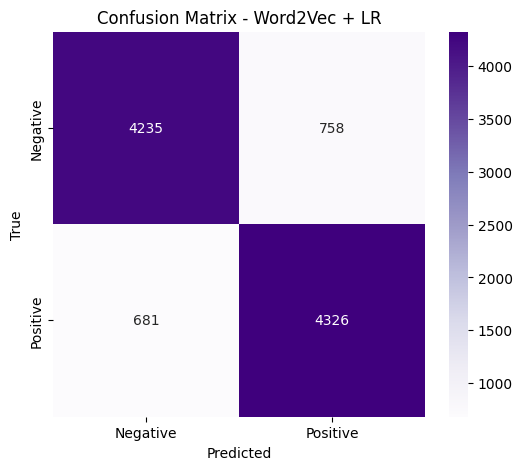

In [39]:
from gensim.models import Word2Vec

# Tokenize processed reviews
tokenized_train = [review.split() for review in train_reviews]
tokenized_test = [review.split() for review in test_reviews]

# Train Word2Vec on your IMDB training data
# CBOW Model (sg=0)
w2v_cbow = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4, sg=0)

# Skip-gram Model (sg=1)
w2v_skipgram = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4, sg=1)

def average_word_vectors(tokenized_reviews, model, vector_size):
    review_vectors = []
    for tokens in tokenized_reviews:
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            vector = np.mean(model.wv[valid_tokens], axis=0)
        else:
            vector = np.zeros(vector_size)
        review_vectors.append(vector)
    return np.array(review_vectors)

X_train_w2v = average_word_vectors(tokenized_train, w2v_cbow, 100)
X_test_w2v = average_word_vectors(tokenized_test, w2v_cbow, 100)

# Skip-gram embeddings
X_train_skip = average_word_vectors(tokenized_train, w2v_skipgram, 100)
X_test_skip = average_word_vectors(tokenized_test, w2v_skipgram, 100)

# Logistic Regression
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, train_labels)

# Logistic Regression
lr_skip = LogisticRegression(max_iter=1000)
lr_skip.fit(X_train_skip, train_labels)

y_pred_skip = lr_skip.predict(X_test_skip)
# Predict
y_pred_w2v = lr_w2v.predict(X_test_w2v)

# Accuracy & report
acc = accuracy_score(test_labels, y_pred_w2v)
print(f"Logistic Regression + Word2Vec Accuracy CBOW: {acc:.4f}")
print("\nClassification Report:\n", classification_report(test_labels, y_pred_w2v))

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_w2v)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Word2Vec + LR")
plt.show()


 Skip-gram + Logistic Regression
Accuracy: 0.8692
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4993
           1       0.87      0.87      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



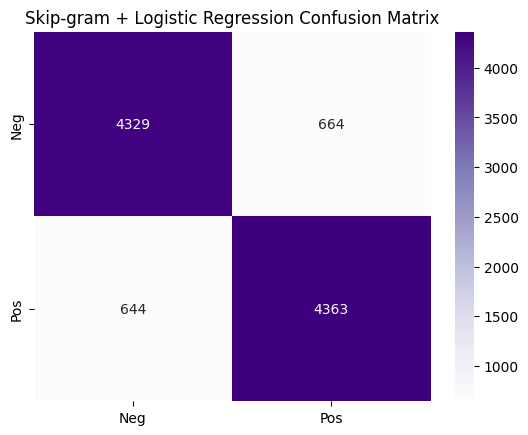

In [40]:
print(" Skip-gram + Logistic Regression")
print(f"Accuracy: {accuracy_score(test_labels, y_pred_skip):.4f}")
print(classification_report(test_labels, y_pred_skip))

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred_skip)
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d", xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.title("Skip-gram + Logistic Regression Confusion Matrix")
plt.show()

In [41]:
# Create copy of test dataframe
df_test = df.iloc[40000:].copy().reset_index(drop=True)

# CBOW Misclassifications
df_test["true"] = test_labels.reset_index(drop=True)
df_test["cbow_pred"] = y_pred_w2v
cbow_mis = df_test[df_test["true"] != df_test["cbow_pred"]]
print("\n CBOW Misclassified Reviews:")
print(cbow_mis[["index","review", "true", "cbow_pred"]].head(5))

# Skip-gram Misclassifications
df_test["skip_pred"] = y_pred_skip
skip_mis = df_test[df_test["true"] != df_test["skip_pred"]]
print("\n Skip-gram Misclassified Reviews:")
print(skip_mis[["index","review", "true", "skip_pred"]].head(5))



 CBOW Misclassified Reviews:
    index                                             review  true  cbow_pred
2   40002  When you look at the cover and read stuff abou...     0          1
18  40018  This movie is stuffed full of stock Horror mov...     1          0
24  40024  I wasn't really interested in seeing Step Up, ...     0          1
39  40039  This must rank as one of Cinema's greatest deb...     0          1
43  40043  Office work, especially in this era of compute...     0          1

 Skip-gram Misclassified Reviews:
    index                                             review  true  skip_pred
2   40002  When you look at the cover and read stuff abou...     0          1
18  40018  This movie is stuffed full of stock Horror mov...     1          0
24  40024  I wasn't really interested in seeing Step Up, ...     0          1
43  40043  Office work, especially in this era of compute...     0          1
53  40053  While William Shater can always make me smile ...     0          1

In [42]:
# Make explicit copies to avoid SettingWithCopyWarning
cbow_mis = cbow_mis.copy()
skip_mis = skip_mis.copy()

# Add method columns
cbow_mis["method"] = "CBOW + LR"
skip_mis["method"] = "Skip-gram + LR"

# Rename for clarity
cbow_mis = cbow_mis.rename(columns={"cbow_pred": "predicted_sentiment"})
skip_mis = skip_mis.rename(columns={"skip_pred": "predicted_sentiment"})

# Select relevant columns
cbow_mis_export = cbow_mis[["index", "review", "true", "predicted_sentiment", "method"]]
skip_mis_export = skip_mis[["index", "review", "true", "predicted_sentiment", "method"]]

# Export to CSVs (add .csv extension for skipgram)
cbow_mis_export.to_csv("cbow_lr.csv", index=False)
skip_mis_export.to_csv("skipgram_lr.csv", index=False)


In [43]:

# Combine both misclassified DataFrames
combined_misclassified = pd.concat([cbow_mis_export, skip_mis_export], ignore_index=True)

# Save to CSV
combined_misclassified.to_csv("combined_lr_word2vec_misclassified_reviews.csv", index=False)
# Create separate DataFrames
false_positives = combined_misclassified[
    (combined_misclassified["true"] == 0) & (combined_misclassified["predicted_sentiment"] == 1)
].copy()

false_negatives = combined_misclassified[
    (combined_misclassified["true"] == 1) & (combined_misclassified["predicted_sentiment"] == 0)
].copy()



In [44]:
display(false_positives,false_negatives)

,index,review,true,predicted_sentiment,method
0,40002,When you look at the cover and read stuff abou...,0,1,CBOW + LR
2,40024,"I wasn't really interested in seeing Step Up, ...",0,1,CBOW + LR
3,40039,This must rank as one of Cinema's greatest deb...,0,1,CBOW + LR
4,40043,"Office work, especially in this era of compute...",0,1,CBOW + LR
5,40062,Comedy Central has a habit of putting on great...,0,1,CBOW + LR
...,...,...,...,...,...
2742,49969,I must admit that this is one of the worst mov...,0,1,Skip-gram + LR
2743,49973,The title leads viewers to believe that this i...,0,1,Skip-gram + LR
2744,49986,This movie is a disgrace to the Major League F...,0,1,Skip-gram + LR
2745,49997,I am a Catholic taught in parochial elementary...,0,1,Skip-gram + LR


,index,review,true,predicted_sentiment,method
1,40018,This movie is stuffed full of stock Horror mov...,1,0,CBOW + LR
6,40080,In my review just submitted I referred to the ...,1,0,CBOW + LR
7,40089,Cutting to the chase: This is one of the most ...,1,0,CBOW + LR
10,40134,"Let's face it, lot's of bad movies are made al...",1,0,CBOW + LR
12,40141,"I throughly enjoyed this short, even as a Toro...",1,0,CBOW + LR
...,...,...,...,...,...
2730,49859,I watched this movie out of a lack of anything...,1,0,Skip-gram + LR
2735,49895,"If you came into the film with expectations, t...",1,0,Skip-gram + LR
2737,49917,Long trailer? whoever said that has got to be ...,1,0,Skip-gram + LR
2738,49931,"Yeah, I guess this movie is kinda dull compare...",1,0,Skip-gram + LR


1. DETECTING NEGATIONS IN FP AND FN

In [45]:
# Reuse the negation detection function
def contains_negation(text):
    return any(neg in text.lower() for neg in [
        "not", "no", "never", "n't", "none", "nothing", "nobody", "neither", "nowhere", "hardly", "scarcely", "barely"
    ])

# Apply to each set
false_positives["has_negation"] = false_positives["review"].apply(contains_negation)
false_negatives["has_negation"] = false_negatives["review"].apply(contains_negation)

print(" False Positives with Negations:")
print(false_positives[false_positives["has_negation"]][["review", "true", "predicted_sentiment", "method"]].head(3))

print("\n False Negatives with Negations:")
print(false_negatives[false_negatives["has_negation"]][["review", "true", "predicted_sentiment", "method"]].head(3))


 False Positives with Negations:
                                              review  true  \
0  When you look at the cover and read stuff abou...     0   
2  I wasn't really interested in seeing Step Up, ...     0   
4  Office work, especially in this era of compute...     0   

   predicted_sentiment     method  
0                    1  CBOW + LR  
2                    1  CBOW + LR  
4                    1  CBOW + LR  

 False Negatives with Negations:
                                              review  true  \
1  This movie is stuffed full of stock Horror mov...     1   
6  In my review just submitted I referred to the ...     1   
7  Cutting to the chase: This is one of the most ...     1   

   predicted_sentiment     method  
1                    0  CBOW + LR  
6                    0  CBOW + LR  
7                    0  CBOW + LR  


## W2V WITH SVM


--- SVM (linear kernel) + Word2Vec (CBOW) ---
Accuracy: 0.8544
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4993
           1       0.85      0.87      0.86      5007

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



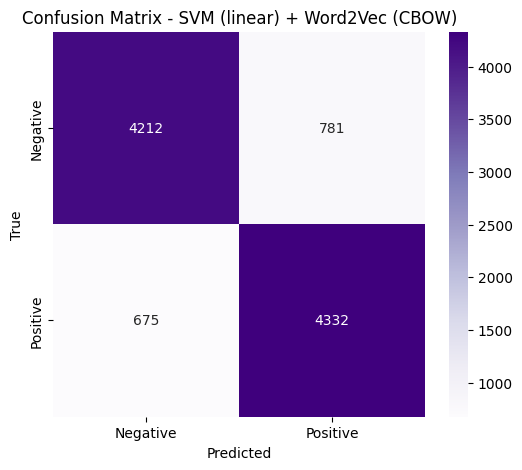


--- SVM (rbf kernel) + Word2Vec (CBOW) ---
Accuracy: 0.8627
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4993
           1       0.85      0.87      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



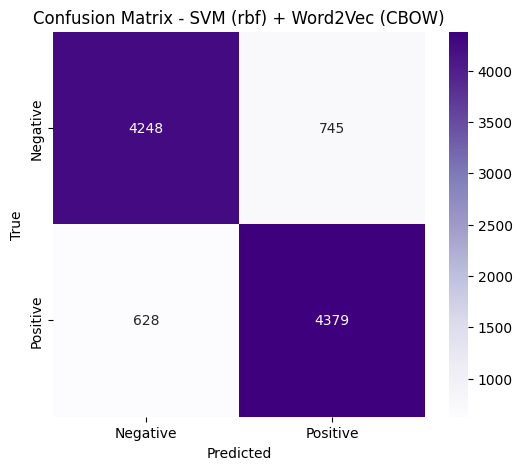


--- SVM (poly kernel) + Word2Vec (CBOW) ---
Accuracy: 0.8616
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4993
           1       0.85      0.87      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



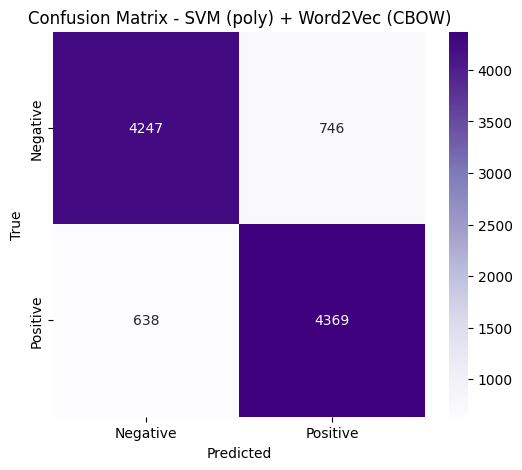


--- SVM (sigmoid kernel) + Word2Vec (CBOW) ---
Accuracy: 0.6739
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.68      4993
           1       0.68      0.67      0.67      5007

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



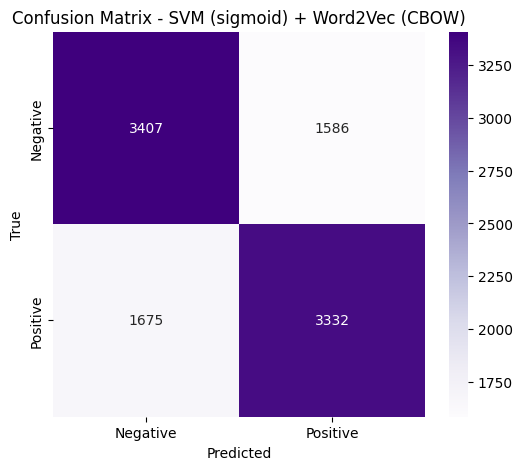


--- SVM (linear kernel) + Word2Vec (Skip-gram) ---
Accuracy: 0.8701
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      4993
           1       0.87      0.87      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



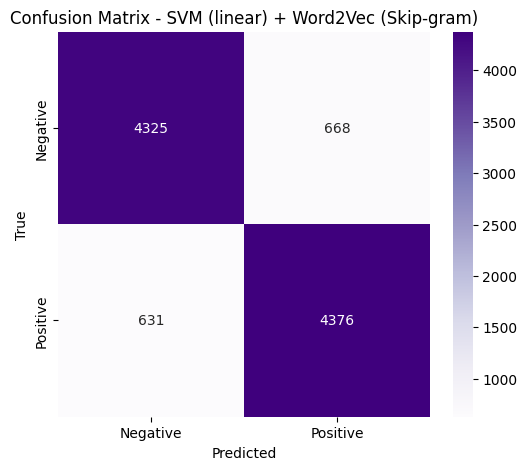


--- SVM (rbf kernel) + Word2Vec (Skip-gram) ---
Accuracy: 0.8712
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      4993
           1       0.87      0.87      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



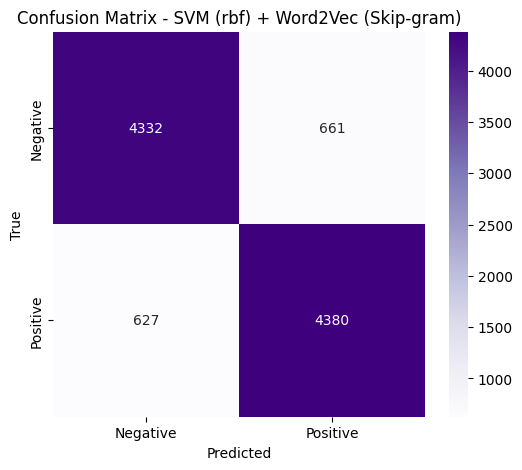


--- SVM (poly kernel) + Word2Vec (Skip-gram) ---
Accuracy: 0.8724
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      4993
           1       0.87      0.88      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



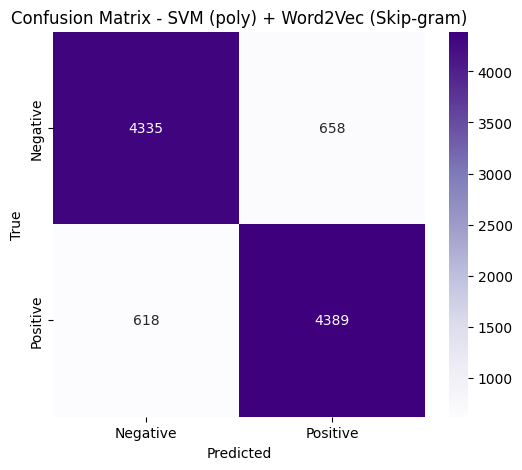


--- SVM (sigmoid kernel) + Word2Vec (Skip-gram) ---
Accuracy: 0.8650
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      4993
           1       0.86      0.87      0.87      5007

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



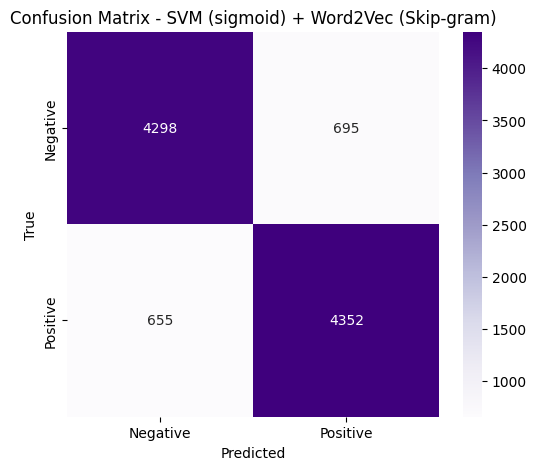

In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_svm_kernels(X_train, X_test, y_train, y_test, label):
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    
    for kernel in kernels:
        print(f"\n--- SVM ({kernel} kernel) + Word2Vec ({label}) ---")
        svm_model = SVC(kernel=kernel)
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        
        # Accuracy & report
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix - SVM ({kernel}) + Word2Vec ({label})")
        plt.show()

# Run for CBOW
evaluate_svm_kernels(X_train_w2v, X_test_w2v, train_labels, test_labels, label="CBOW")

# Run for Skip-gram
evaluate_svm_kernels(X_train_skip, X_test_skip, train_labels, test_labels, label="Skip-gram")


In [49]:
# Train SVM with poly kernel on Skip-gram embeddings
svm_model_poly_skip = SVC(kernel='poly')
svm_model_poly_skip.fit(X_train_skip, train_labels)
y_pred_svm_skip_poly = svm_model_poly_skip.predict(X_test_skip)

# Get misclassified indices
misclassified_indices_poly = (y_pred_svm_skip_poly != test_labels)

# Extract misclassified reviews
misclassified_reviews_poly = test_reviews[misclassified_indices_poly]
true_labels_poly = test_labels[misclassified_indices_poly]
predicted_labels_poly = y_pred_svm_skip_poly[misclassified_indices_poly]

# Create DataFrame
df_misclassified_poly = pd.DataFrame({
    'review': misclassified_reviews_poly,
    'true_label': true_labels_poly,
    'predicted_label': predicted_labels_poly
})

# Save to CSV
df_misclassified_poly.to_csv("svm_poly_skipgram_w2v.csv", index=False)
print("Saved misclassified reviews for Skip-gram + SVM (poly kernel) to 'svm_poly_skipgram_w2v.csv'")


Saved misclassified reviews for Skip-gram + SVM (poly kernel) to 'svm_poly_skipgram_w2v.csv'


In [50]:
# Get misclassified indices
misclassified_indices_lr = (y_pred_svm_skip_poly != test_labels.to_numpy()).nonzero()[0]

# Create misclassified DataFrame
misclassified_lr_df = pd.DataFrame({
    "index": df["index"].iloc[40000 + pd.Series(misclassified_indices_lr)].values,
    "original_review": df["review"].iloc[40000 + pd.Series(misclassified_indices_lr)].values,
    "processed_review": df["processed_review"].iloc[40000 + pd.Series(misclassified_indices_lr)].values,
    "true_sentiment": test_labels.iloc[misclassified_indices_lr].map({1: "positive", 0: "negative"}).values,
    "predicted_sentiment": [ "positive" if pred == 1 else "negative" for pred in y_pred_svm_skip_poly[misclassified_indices_lr] ]
})



In [51]:
print("\nSample Misclassified Reviews - W2V (sg) with SVM (poly):")
for i in range(8):
    row = misclassified_lr_df.iloc[i]
    print(f"\nReview #{row['index']}")
    print(f"Original Review:\n{row['original_review']}")
    print(f"True Sentiment: {row['true_sentiment']} | Predicted Sentiment: {row['predicted_sentiment']}")


Sample Misclassified Reviews - W2V (sg) with SVM (poly):

Review #40002
Original Review:
When you look at the cover and read stuff about it an entirely different type of movie comes to mind than what you get here. Then again maybe I read the summary for the other movie called "Mausolem" instead as there were two movies of this title released about the same time with both featuring plots that had key elements in common. However, reading stuff about that movie here I know I saw this one and not that one and that movie is even less what one would imagine a movie with that title would be about. I will be honest, I expect more of a zombie type picture and you get that in this movie to some degree. However, there is more stuff involving the occult and strange powers as the opening scene of the people being taken away by the coroner at the beginning of the film will attest to. The movie also has the old theme of kids going somewhere they do not belong to have some crazy party, in this case i

## W2V with LSTM (Skipgram)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      18,161,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,161,100 (69.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,161,100 (69.28 MB)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 166ms/step - accuracy: 0.6995 - loss: 0.5667 - val_accuracy: 0.7812 - val_loss: 0.4421
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.7708 - loss: 0.4797 - val_accuracy: 0.8307 - val_loss: 0.4031
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.8016 - loss: 0.4302 - val_accuracy: 0.8516 - val_loss: 0.3470
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.8219 - loss: 0.3940 - val_accuracy: 0.8545 - val_loss: 0.3340
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.8336 - loss: 0.3707 - val_accuracy: 0.8646 - val_loss: 0.3143
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step
Accuracy: 0.8695
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      4993
           1       0.87      0.87      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     

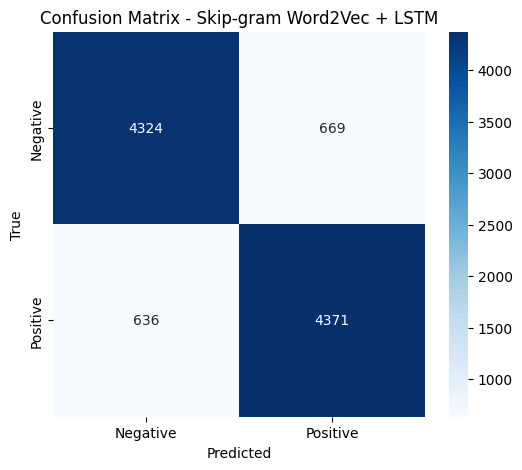

In [52]:
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tokenize the processed training corpus for Word2Vec
tokenized_corpus = [review.split() for review in train_reviews]

# 2. Train Word2Vec (Skip-gram)
w2v_skip = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, sg=1, min_count=1, workers=4)

# 3. Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_reviews)

X_train_seq = tokenizer.texts_to_sequences(train_reviews)
X_test_seq = tokenizer.texts_to_sequences(test_reviews)

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

# 4. Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in w2v_skip.wv:
        embedding_matrix[idx] = w2v_skip.wv[word]

# 5. Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_len, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 6. Train the model
history = model.fit(X_train_pad, train_labels, batch_size=128, epochs=5, validation_split=0.2)

# 7. Evaluate on test set
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
acc = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(test_labels, y_pred))

# 8. Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Skip-gram Word2Vec + LSTM")
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      18,161,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,161,100 (69.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,161,100 (69.28 MB)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.6841 - loss: 0.5817 - val_accuracy: 0.8023 - val_loss: 0.4291 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.7761 - loss: 0.4746 - val_accuracy: 0.8299 - val_loss: 0.3879 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 149ms/step - accuracy: 0.8006 - loss: 0.4325 - val_accuracy: 0.8276 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.8212 - loss: 0.3977 - val_accuracy: 0.8587 - val_loss: 0.3319 - learning_rate: 0.0010
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.8399 - loss: 0.3685 - val_accuracy: 0.8530 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.8468 - loss: 0.3523 - val_accuracy: 0.8649 - val_loss: 0.3170 - learning_rate: 0.0010
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.8

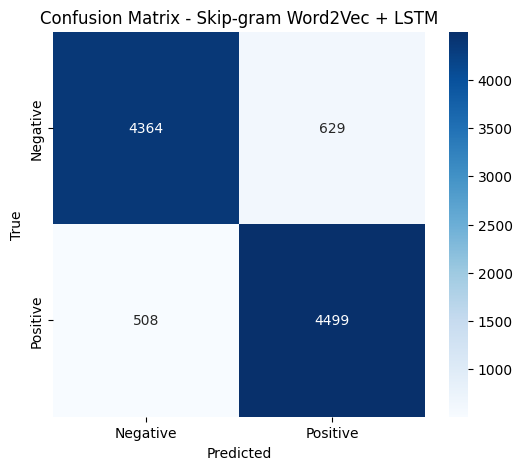

In [53]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# Create EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',       # Metric to monitor (commonly val_loss or val_accuracy)
    patience=3,               # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)
# 1. Tokenize the processed training corpus for Word2Vec
tokenized_corpus = [review.split() for review in train_reviews]

# 2. Train Word2Vec (Skip-gram)
w2v_skip = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, sg=1, min_count=1, workers=4)

# 3. Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_reviews)

X_train_seq = tokenizer.texts_to_sequences(train_reviews)
X_test_seq = tokenizer.texts_to_sequences(test_reviews)

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

vocab_size = len(tokenizer.word_index) + 1

# 4. Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in w2v_skip.wv:
        embedding_matrix[idx] = w2v_skip.wv[word]

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)
# 5. Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_len, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 6. Train the model
history = model.fit(
    X_train_pad,
    train_labels,
    validation_split=0.2,
    epochs=15,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)

# 7. Evaluate on test set
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
acc = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(test_labels, y_pred))

# 8. Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Skip-gram Word2Vec + LSTM")
plt.show()


In [54]:

# Predict on test set
y_pred_lstm_probs = model.predict(X_test_pad, batch_size=128, verbose=1)
y_pred_lstm = (y_pred_lstm_probs >= 0.5).astype(int).flatten()

# Identify misclassified indices
misclassified_mask = (y_pred_lstm != test_labels)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step


In [57]:
# Identify misclassified indices
misclassified_indices = (y_pred_lstm != test_labels.to_numpy()).nonzero()[0]

print("\nSample Misclassified Reviews (W2V + LSTM):")
for idx in misclassified_indices_[:8]:
    true_sentiment = "positive" if test_labels.iloc[idx] == 1 else "negative"
    predicted_sentiment = "positive" if y_pred_lstm[idx] == 1 else "negative"
    
    print(f"\nReview #{idx + 1}")
    print(f"Original Review:\n{df['review'].iloc[40000 + idx]}")
    print(f"True Sentiment: {true_sentiment}")
    print(f"Predicted Sentiment: {predicted_sentiment}")



Sample Misclassified Reviews (W2V + LSTM):

Review #3
Original Review:
When you look at the cover and read stuff about it an entirely different type of movie comes to mind than what you get here. Then again maybe I read the summary for the other movie called "Mausolem" instead as there were two movies of this title released about the same time with both featuring plots that had key elements in common. However, reading stuff about that movie here I know I saw this one and not that one and that movie is even less what one would imagine a movie with that title would be about. I will be honest, I expect more of a zombie type picture and you get that in this movie to some degree. However, there is more stuff involving the occult and strange powers as the opening scene of the people being taken away by the coroner at the beginning of the film will attest to. The movie also has the old theme of kids going somewhere they do not belong to have some crazy party, in this case it is in fact a mau

In [58]:
# 5. Extract misclassified reviews and their labels
misclassified_reviews = df['review'].iloc[40000 + misclassified_indices]
true_labels = test_labels.iloc[misclassified_indices].map({1: "positive", 0: "negative"}).values
predicted_labels = pd.Series(y_pred_lstm[misclassified_indices]).map({1: "positive", 0: "negative"}).values

# 6. Create DataFrame
df_misclassified = pd.DataFrame({
    'review': misclassified_reviews.values,
    'true_label': true_labels,
    'predicted_label': predicted_labels
})

# 7. Save to CSV
df_misclassified.to_csv("w2v_skipgram_lstm_misclassified.csv", index=False)
print("Saved misclassified reviews to 'w2v_skipgram_lstm_misclassified.csv'")


Saved misclassified reviews to 'w2v_skipgram_lstm_misclassified.csv'


# W2V WITH BILSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      18,161,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,161,100 (69.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,161,100 (69.28 MB)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 214ms/step - accuracy: 0.6780 - loss: 0.5894 - val_accuracy: 0.8131 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 210ms/step - accuracy: 0.7817 - loss: 0.4727 - val_accuracy: 0.8314 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - accuracy: 0.8014 - loss: 0.4368 - val_accuracy: 0.8311 - val_loss: 0.3729 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step
Accuracy: 0.8144
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      4993
           1       0.89      0.72      0.80      5007

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.83      0.81      0.81     10000



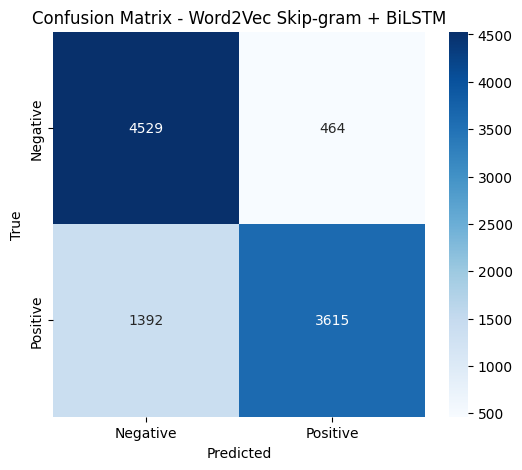

Saved misclassified reviews to 'w2v_skipgram_bilstm_misclassified.csv'


In [59]:
from tensorflow.keras.layers import Embedding, Bidirectional


# 6. Build BiLSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# 7. Train the model
history = model.fit(
    X_train_pad,
    train_labels,
    validation_split=0.2,
    epochs=15,
    batch_size=128,
    callbacks=[early_stop, reduce_lr]
)

# 8. Predict and Evaluate
y_pred_bilstm = (model.predict(X_test_pad) > 0.5).astype("int32").flatten()

acc = accuracy_score(test_labels, y_pred_bilstm)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(test_labels, y_pred_bilstm))

# 9. Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_bilstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Word2Vec Skip-gram + BiLSTM")
plt.show()

# 10. Save misclassified reviews
misclassified_indices = (y_pred_bilstm != test_labels.to_numpy()).nonzero()[0]

misclassified_reviews = df['review'].iloc[40000 + misclassified_indices]
true_labels = test_labels.iloc[misclassified_indices].map({1: "positive", 0: "negative"}).values
predicted_labels = pd.Series(y_pred_bilstm[misclassified_indices]).map({1: "positive", 0: "negative"}).values

df_misclassified = pd.DataFrame({
    'review': misclassified_reviews.values,
    'true_label': true_labels,
    'predicted_label': predicted_labels
})
df_misclassified.to_csv("w2v_skipgram_bilstm_misclassified.csv", index=False)
print("Saved misclassified reviews to 'w2v_skipgram_bilstm_misclassified.csv'")

In [60]:
# Print sample misclassified reviews
print("\nSample Misclassified Reviews (Word2Vec Skip-gram + BiLSTM):")
for idx in range(min(8, len(df_misclassified))):
    print(f"\nReview #{idx + 1}")
    print(f"Original Review:\n{df_misclassified['review'].iloc[idx]}")
    print(f"True Sentiment: {df_misclassified['true_label'].iloc[idx]}")
    print(f"Predicted Sentiment: {df_misclassified['predicted_label'].iloc[idx]}")



Sample Misclassified Reviews (Word2Vec Skip-gram + BiLSTM):

Review #1
Original Review:
When you look at the cover and read stuff about it an entirely different type of movie comes to mind than what you get here. Then again maybe I read the summary for the other movie called "Mausolem" instead as there were two movies of this title released about the same time with both featuring plots that had key elements in common. However, reading stuff about that movie here I know I saw this one and not that one and that movie is even less what one would imagine a movie with that title would be about. I will be honest, I expect more of a zombie type picture and you get that in this movie to some degree. However, there is more stuff involving the occult and strange powers as the opening scene of the people being taken away by the coroner at the beginning of the film will attest to. The movie also has the old theme of kids going somewhere they do not belong to have some crazy party, in this case it

In [61]:

# Load misclassified review CSVs
svm_mis = pd.read_csv("svm_poly_skipgram_w2v.csv")
lr_mis = pd.read_csv("skipgram_lr.csv")
lstm_mis = pd.read_csv("w2v_skipgram_lstm_misclassified.csv")
bilstm_mis = pd.read_csv("w2v_skipgram_bilstm_misclassified.csv")

# Print number of misclassified reviews for each model
print("Misclassified Review Counts:")
print(f"SVM (poly kernel):         {len(svm_mis)}")
print(f"Logistic Regression:       {len(lr_mis)}")
print(f"LSTM (Skip-gram W2V):      {len(lstm_mis)}")
print(f"BiLSTM (Skip-gram W2V):    {len(bilstm_mis)}")


Misclassified Review Counts:
SVM (poly kernel):         1276
Logistic Regression:       1308
LSTM (Skip-gram W2V):      1137
BiLSTM (Skip-gram W2V):    1856


In [63]:
only_svm = set(svm_mis["review"]) - set(lr_mis["review"]) - set(lstm_mis["review"]) - set(bilstm_mis["review"])
only_lr = set(lr_mis["review"]) - set(svm_mis["review"]) - set(lstm_mis["review"]) - set(bilstm_mis["review"])
only_lstm = set(lstm_mis["review"]) - set(svm_mis["review"]) - set(lr_mis["review"]) - set(bilstm_mis["review"])
only_bilstm = set(bilstm_mis["review"]) - set(svm_mis["review"]) - set(lr_mis["review"]) - set(lstm_mis["review"])

print(f"\nReviews only misclassified by SVM (poly): {len(only_svm)}")
print(f"Reviews only misclassified by Logistic Regression: {len(only_lr)}")
print(f"Reviews only misclassified by LSTM: {len(only_lstm)}")
print(f"Reviews only misclassified by BiLSTM: {len(only_bilstm)}")



Reviews only misclassified by SVM (poly): 1273
Reviews only misclassified by Logistic Regression: 273
Reviews only misclassified by LSTM: 238
Reviews only misclassified by BiLSTM: 806
